In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_cst_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(20, 90, 71)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:71,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((71,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_86508/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.4
1     522     0:01.8
2     993     0:03.0
3     1467    0:04.2
20    7995    0:20.2
40    13515   0:34.5
60    19056   0:48.8
80    24624   1:03.2
100   30360   1:18.0
120   35937   1:32.2
140   41316   1:45.8
160   47145   2:00.2
180   52818   2:14.3
200   58374   2:28.5
220   63744   2:42.1
240   69150   2:55.5
260   74925   3:09.6
280   80658   3:23.8
300   86112   3:37.2
320   91899   3:51.9
340   97485   4:06.0
360   103230   4:20.4
380   109239   4:35.2
400   114987   4:49.4
420   120675   5:03.8
440   126189   5:17.5
460   131913   5:32.2
480   137763   5:47.5
500   143478   6:02.4
520   149355   6:17.6
540   154881   6:31.6
560   160479   6:45.8
580   165990   7:00.4
600   171558   7:15.7
620   177393   7:31.2
640   183282   7:47.4
660   188877   8:03.5
680   194559   8:20.1
700   200223   8:36.5
720   205683   8:52.2
740   211683   9:09.6
760   217509   9:

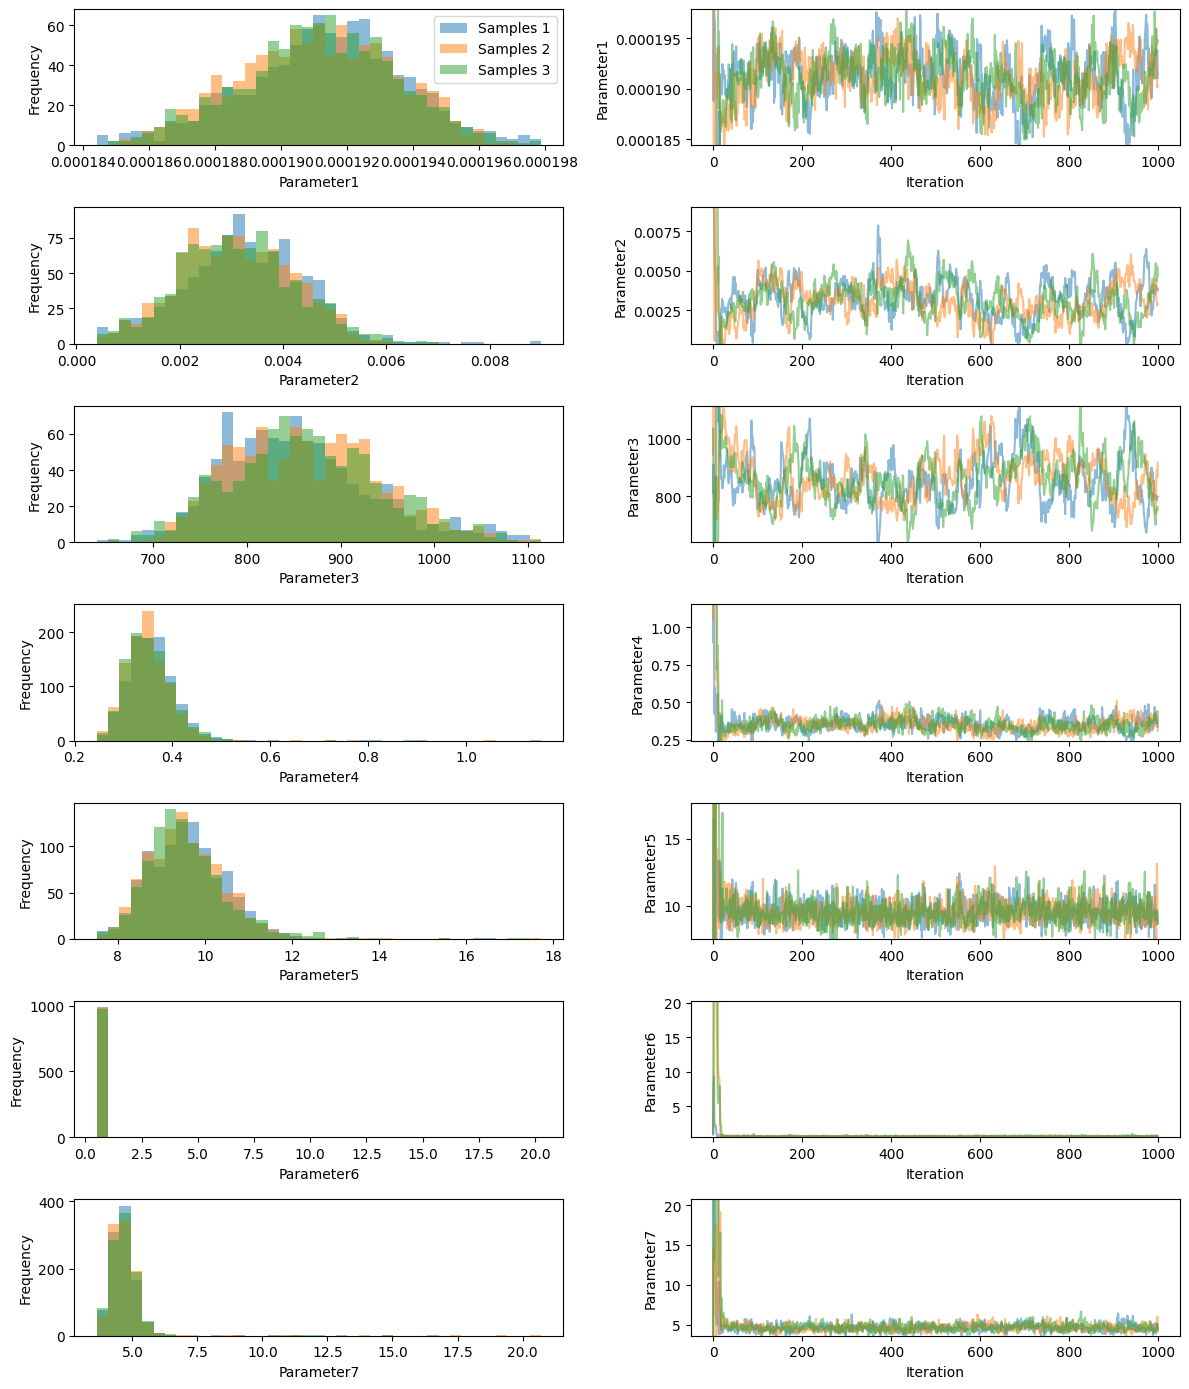

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [26]:

y0 = np.array([0.0003, 0.01, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)


Estimated parameters:
[1.91275900e-04 3.11720249e-03 8.53718516e+02 3.44273778e-01
 9.26853669e+00 6.38190780e-01 4.52314350e+00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_optimisers/_xnes.py:82: UserWarning: All points requested by XNES are outside the boundaries.
  warnings.warn(


Estimated parameters:
[1.91275899e-04 3.11720207e-03 8.53718540e+02 3.44273767e-01
 9.26853745e+00 6.38190816e-01 4.52314375e+00]
Estimated parameters:
[1.91275901e-04 3.11720324e-03 8.53718444e+02 3.44273786e-01
 9.26853618e+00 6.38190739e-01 4.52314359e+00]
Estimated parameters:
[1.91275897e-04 3.11720186e-03 8.53718564e+02 3.44273768e-01
 9.26853739e+00 6.38190795e-01 4.52314358e+00]
Estimated parameters:
[1.91275901e-04 3.11720331e-03 8.53718449e+02 3.44273813e-01
 9.26853621e+00 6.38190766e-01 4.52314327e+00]
Estimated parameters:
[1.91275898e-04 3.11720256e-03 8.53718511e+02 3.44273802e-01
 9.26853624e+00 6.38190762e-01 4.52314365e+00]
Estimated parameters:
[1.91275901e-04 3.11720318e-03 8.53718438e+02 3.44273798e-01
 9.26853675e+00 6.38190807e-01 4.52314339e+00]
Estimated parameters:
[1.91275898e-04 3.11720186e-03 8.53718559e+02 3.44273772e-01
 9.26853691e+00 6.38190798e-01 4.52314375e+00]


In [25]:
print(log_likelihood([1.91275899e-04, 3.11720293e-03, 8.53718500e+02, 3.44273769e-01,
 9.26853687e+00, 6.38190763e-01, 4.52314371e+00]))

AIC = 2*7 - 2*log_likelihood([1.91275899e-04, 3.11720293e-03, 8.53718500e+02, 3.44273769e-01,
 9.26853687e+00, 6.38190763e-01, 4.52314371e+00])

print(AIC)

-560.6267079036027
1135.2534158072053


In [11]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[1.93826069e-04 5.06456105e-03 7.70092228e+02 3.53875396e-01
 9.28990217e+00 5.89244443e-01 4.74124733e+00]
[[1.93826069e-04 5.06456105e-03 7.70092228e+02 ... 9.28990217e+00
  5.89244443e-01 4.74124733e+00]
 [1.92747093e-04 4.93051050e-03 7.73243186e+02 ... 9.86465262e+00
  5.94154516e-01 4.94263432e+00]
 [1.94479714e-04 4.17943052e-03 7.72496013e+02 ... 8.38436181e+00
  6.86689958e-01 4.44197151e+00]
 ...
 [1.93603171e-04 3.96383719e-03 7.84307659e+02 ... 9.62795197e+00
  7.07862262e-01 5.00315754e+00]
 [1.93798995e-04 3.74957660e-03 7.98941016e+02 ... 8.81619176e+00
  6.38938790e-01 4.21101257e+00]
 [1.91094759e-04 3.86074677e-03 7.97647555e+02 ... 8.73950816e+00
  6.45679370e-01 4.62785746e+00]]


In [12]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


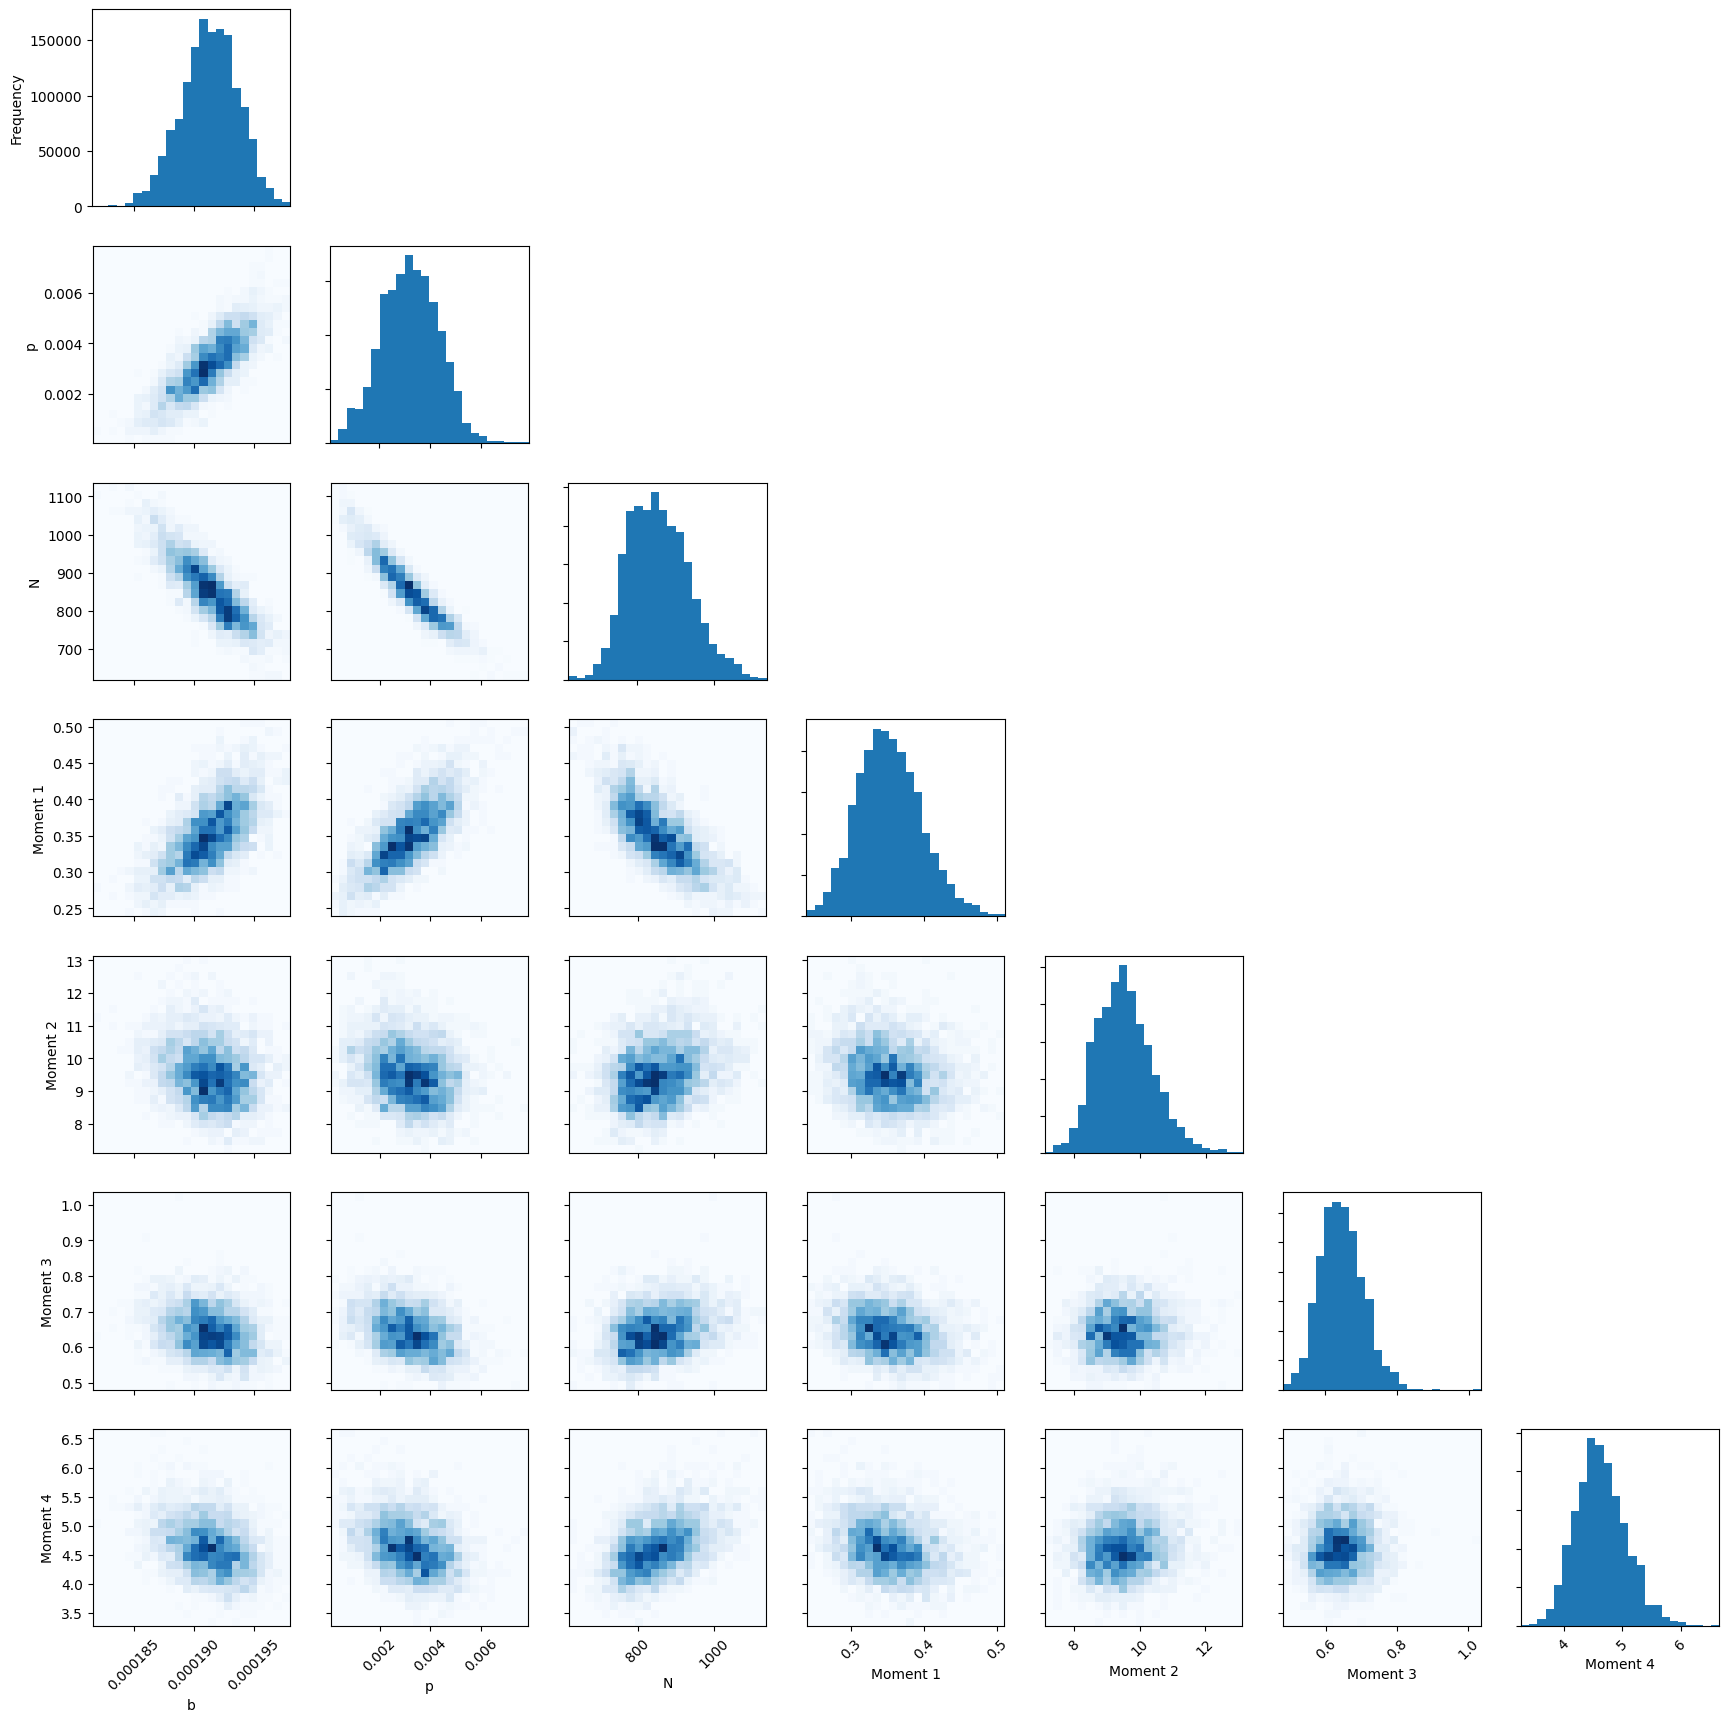

In [14]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

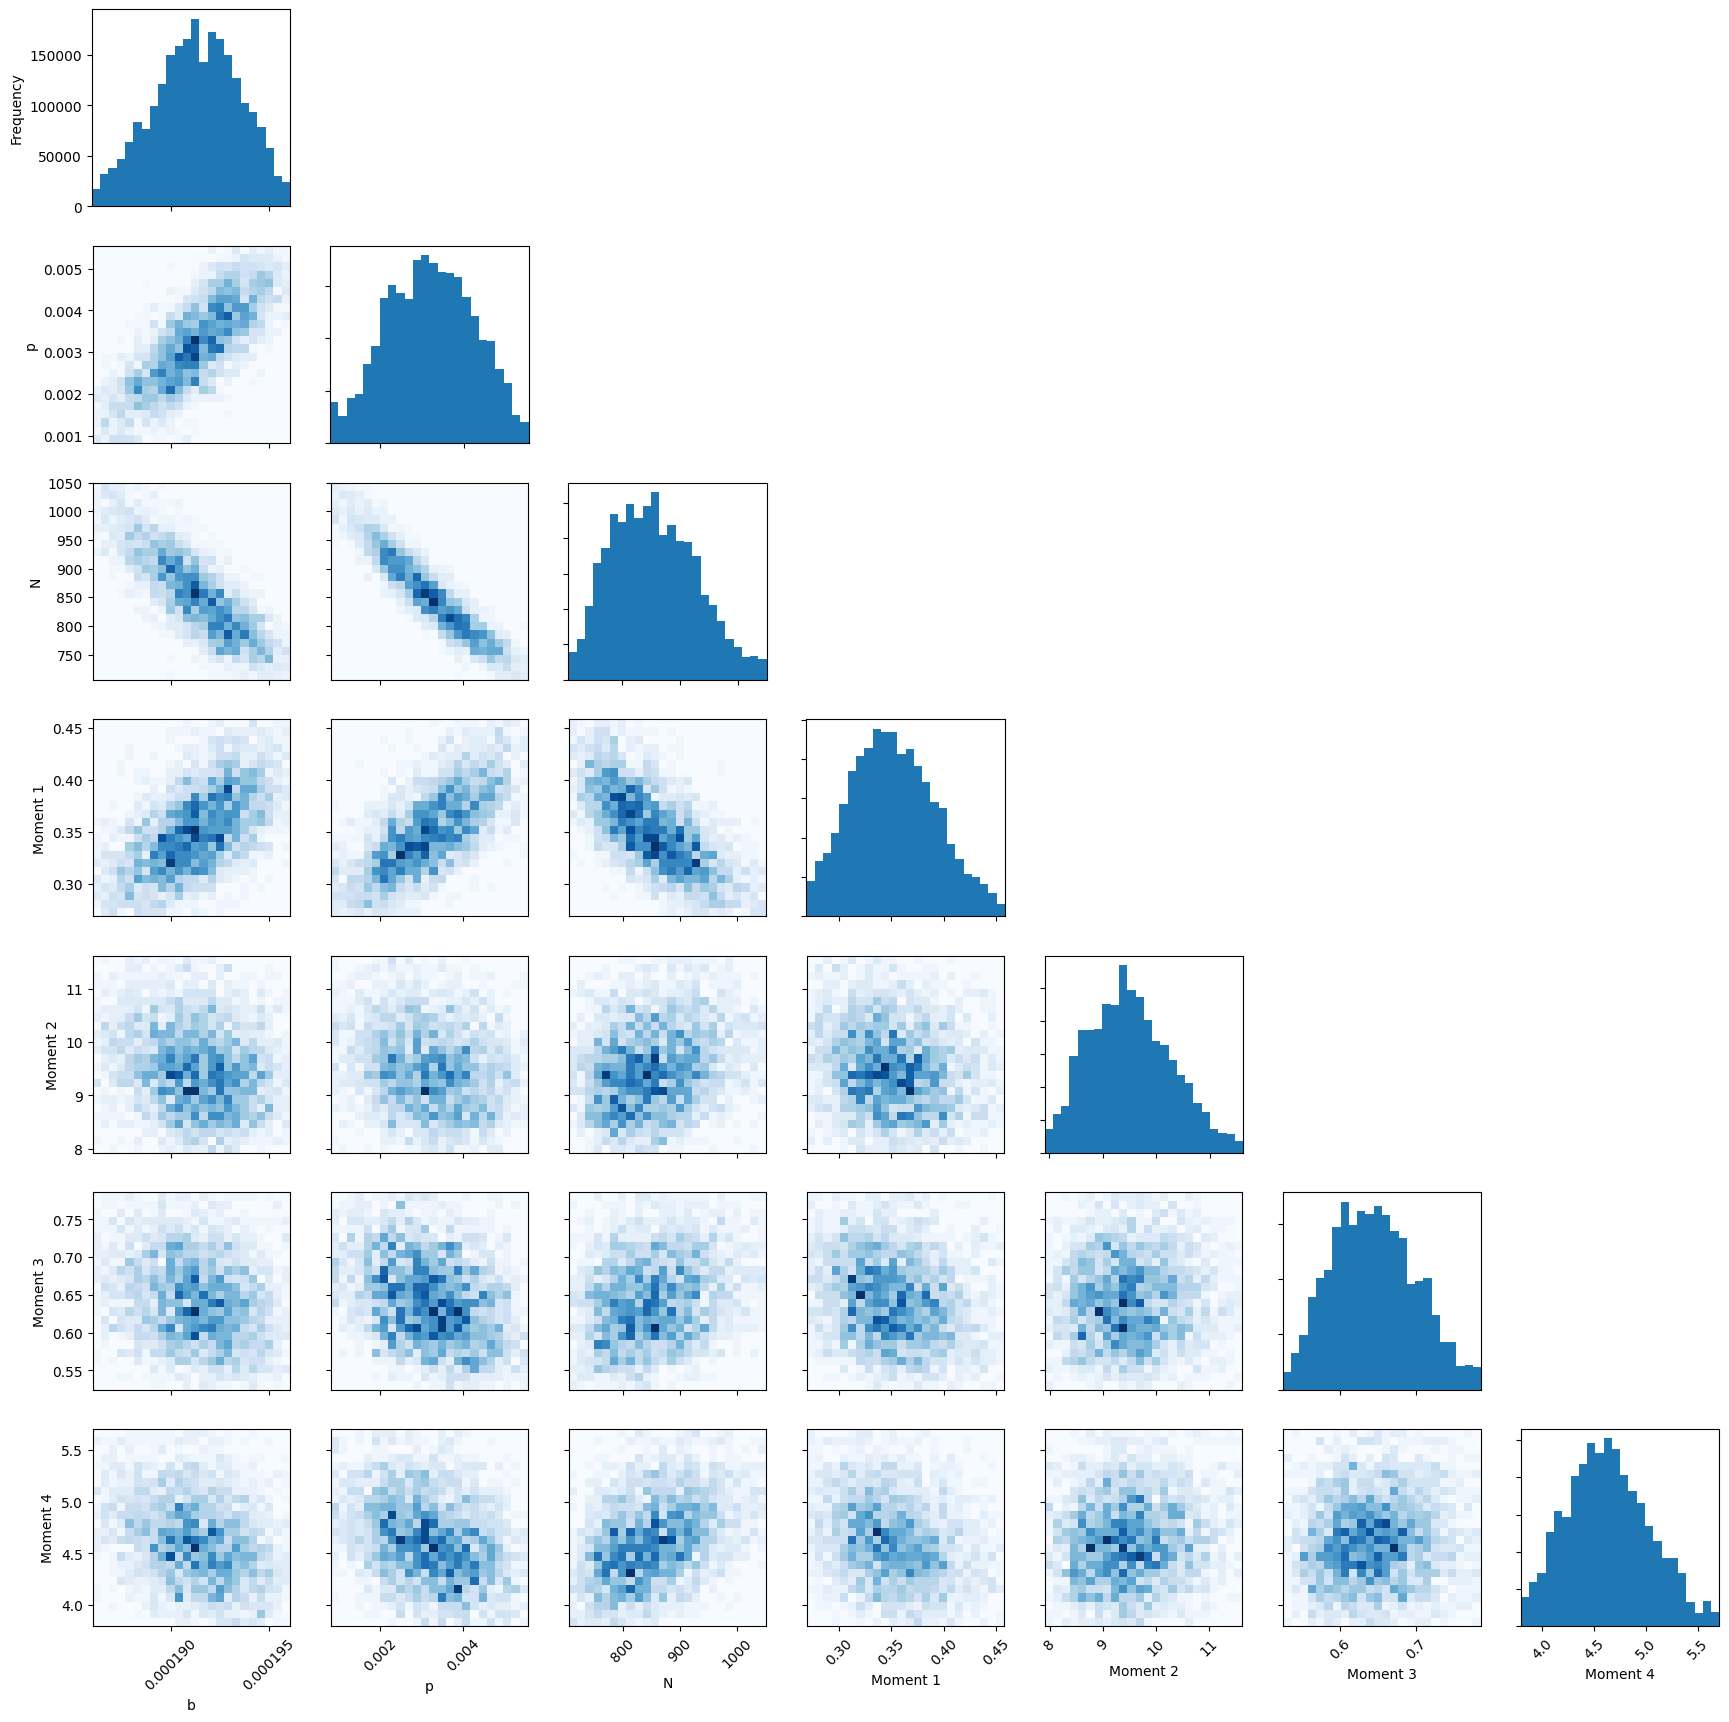

In [15]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

[1.93826069e-04 5.06456105e-03 7.70092228e+02 3.53875396e-01
 9.28990217e+00 5.89244443e-01 4.74124733e+00]


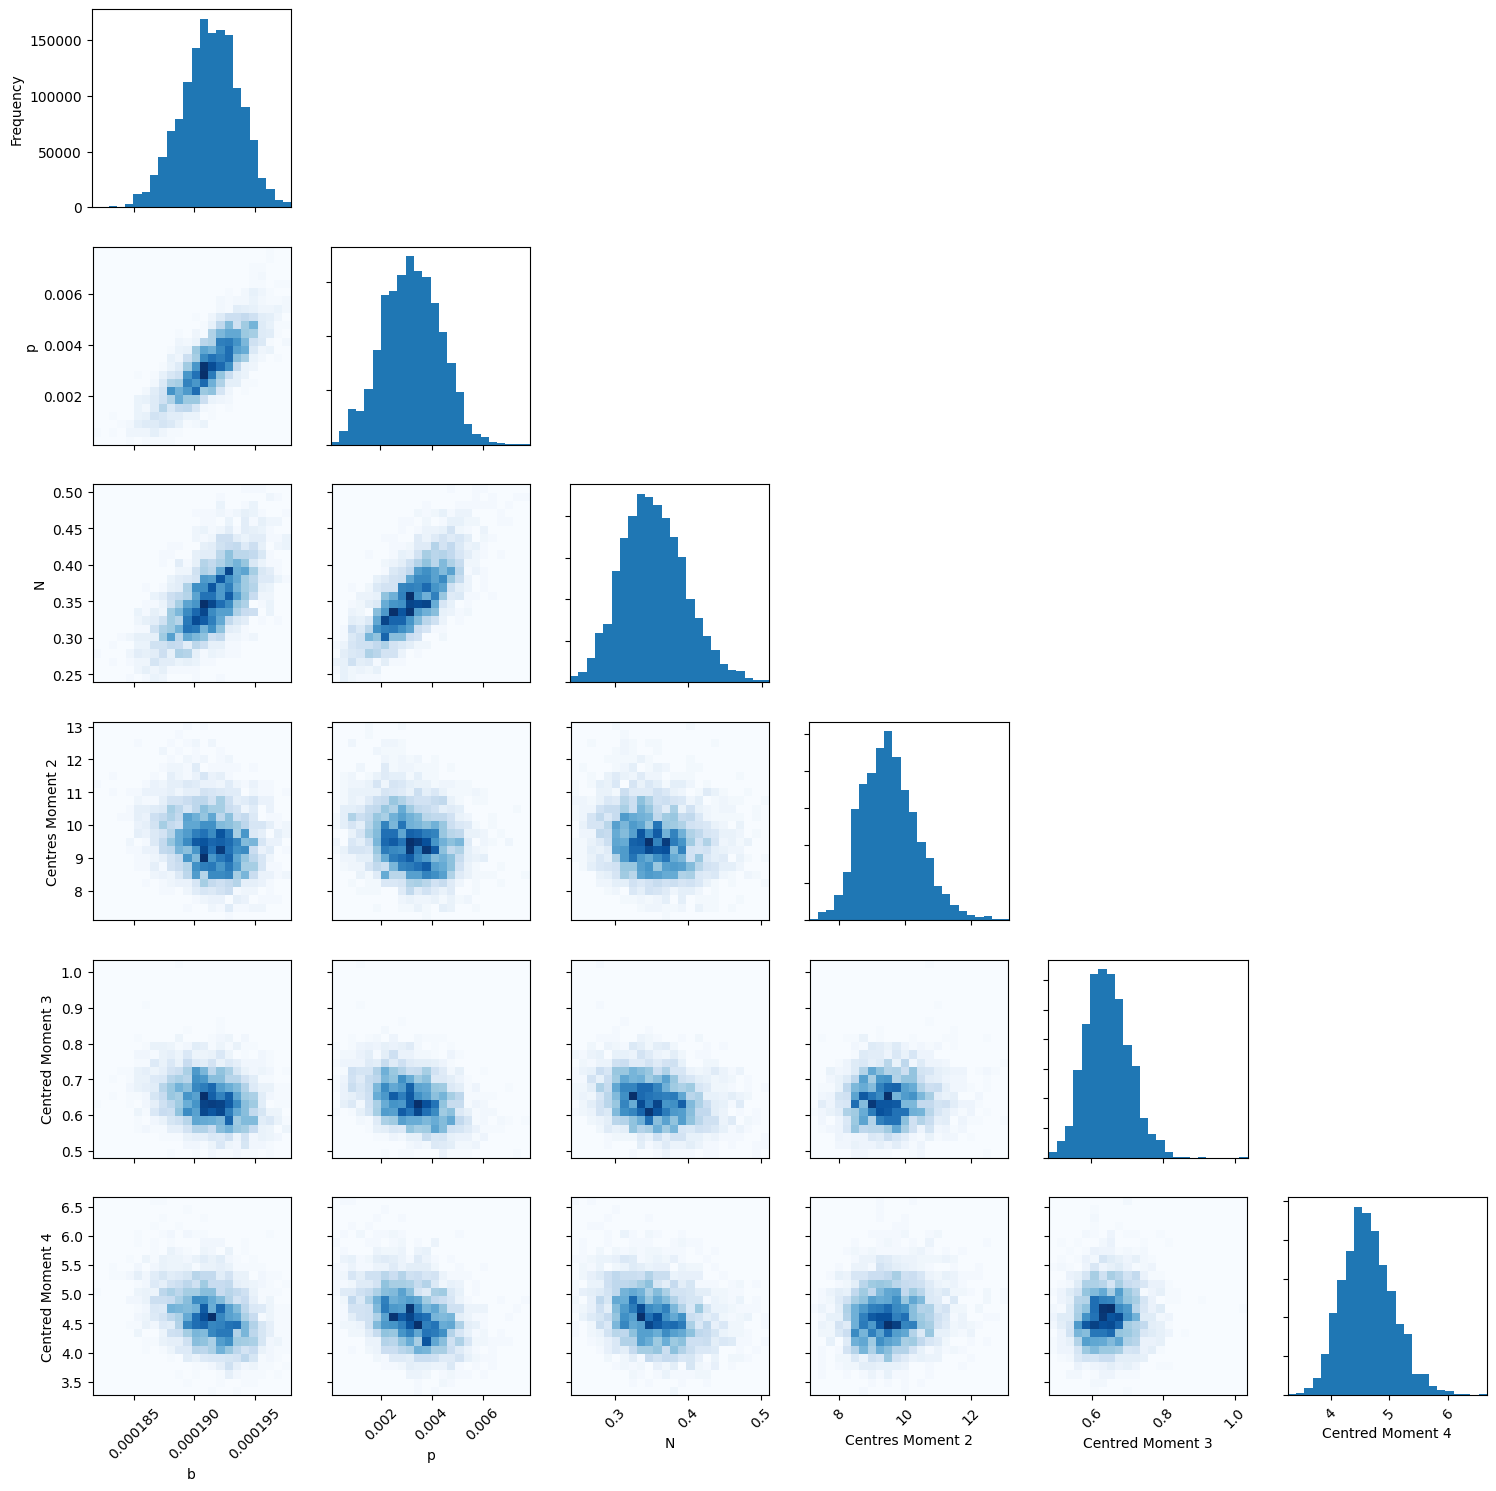

In [17]:
parameter_names = ["b","p","N", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5,6]], heatmap=True, 
                    parameter_names=["b","p","N", "Centres Moment 2", "Centred Moment 3", "Centred Moment 4"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [18]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.02    69.01   0.09
p         0.00    0.00    0.00    0.00    0.00    0.00    0.01     1.02    57.74   0.08
N         873.51  84.76   724.06  808.62  874.54  928.64  1052.03  1.02    56.40   0.08
Moment 1  0.35    0.04    0.27    0.31    0.34    0.37    0.44     1.02    83.83   0.11
Moment 2  9.60    0.88    8.07    9.01    9.52    10.16   11.53    1.00    398.77  0.53
Moment 3  0.65    0.06    0.55    0.60    0.65    0.69    0.78     1.00    366.11  0.49
Moment 4  4.67    0.45    3.90    4.36    4.64    4.95    5.62     1.01    210.49  0.28


In [19]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [20]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         0.000191  2.49e-06  0.000186  0.000189  0.000191  0.000193  0.000196  1.02    69     0.0924
p         0.00296   0.00116   0.000819  0.00215   0.00285   0.0038    0.00523   1.02    57.7   0.0773
N         874       84.8      724       809       875       929       1.05e+03  1.02    56.4   0.0755
Moment 1  0.346     0.0441    0.269     0.314     0.341     0.374     0.442     1.02    83.8   0.112
Moment 2  9.6       0.88      8.07      9.01      9.52      10.2      11.5      1       399    0.534
Moment 3  0.65      0.0613    0.546     0.605     0.647     0.691     0.78      1       366    0.49
Moment 4  4.67      0.446     3.9       4.36      4.64      4.95      5.62      1.01    210    0.282


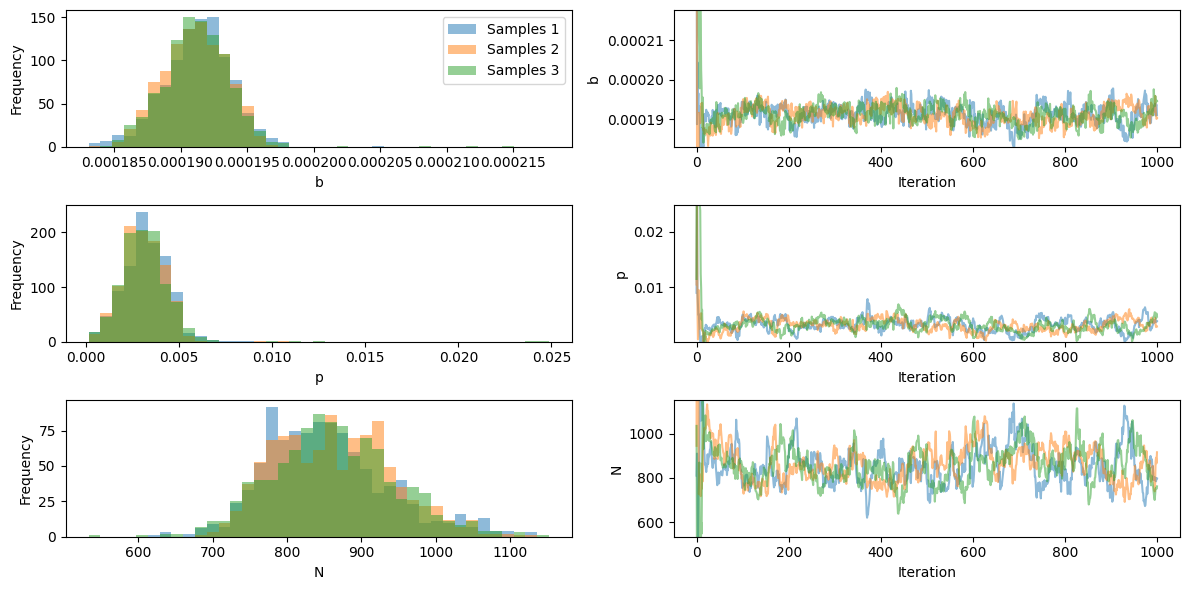

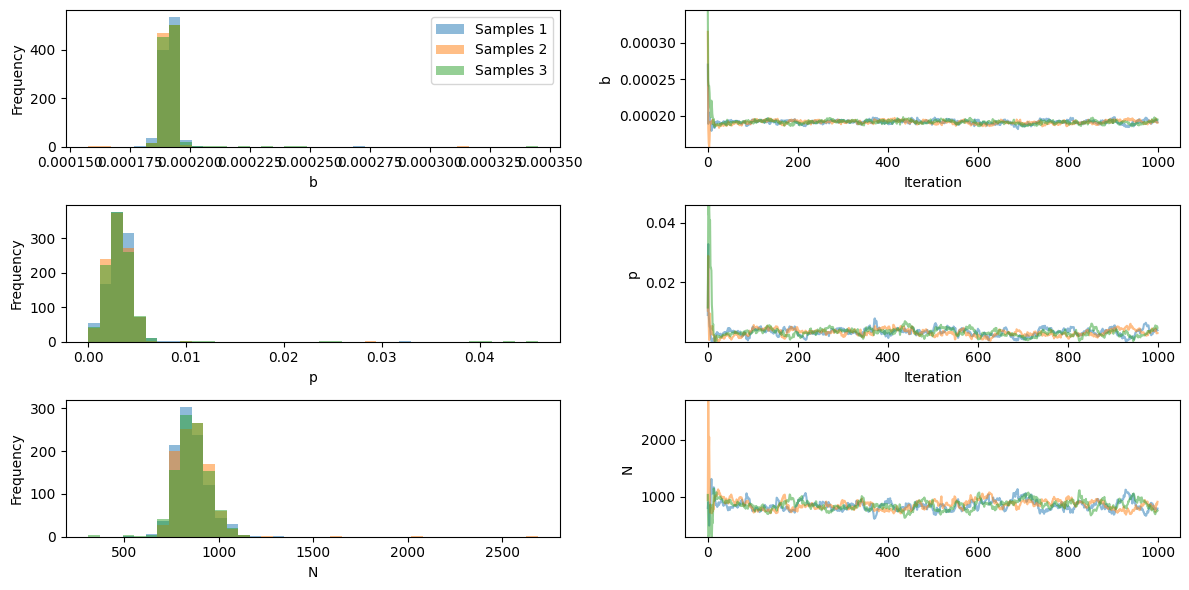

In [22]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

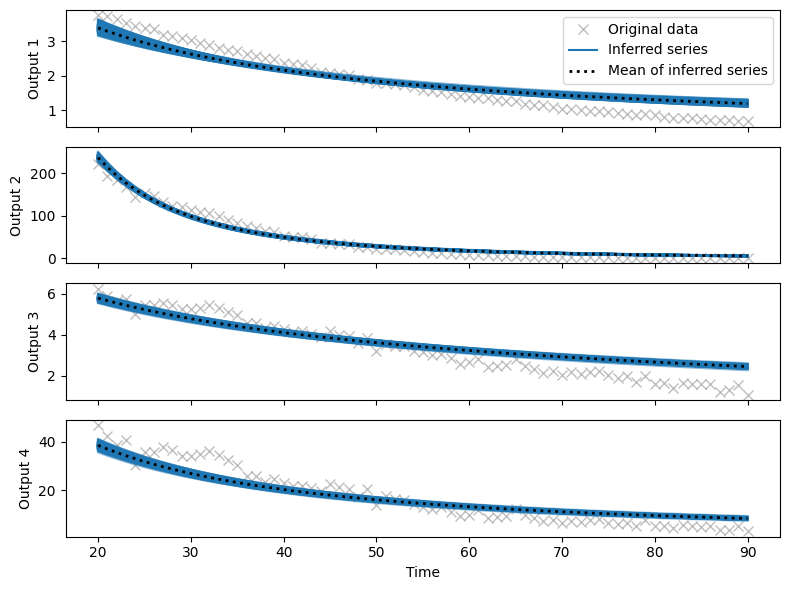

In [23]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

In [ ]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):

plt.plot(data_mean)

IndentationError: expected an indented block after 'for' statement on line 6 (2233855271.py, line 8)